<a href="https://colab.research.google.com/github/tnnz20/Exercise-Tensorflow/blob/master/Time%20series%2C%20sequences%20and%20predictions/Multivariate/household_electric_power_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series, sequences and predictions
Multivariate - Household Electric Power Consumption

## Importing Module

In [1]:
import os
import csv
import urllib
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.2


## Problem

- Build and train a neural network to predict time indexed variables of the multivariate house hold electric power consumption time series dataset
- Using a window of past 24 observations of the 7 variables, the model should be trained to predict the next 24 observations of the 7 variables.

### Preparing data

In [2]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/certificate/household_power.zip'
name_file = 'household_power.zip'

target_path = 'data/'

if os.path.isfile(name_file):
    print(f'{name_file} Already exist')
else:
  # Download file
  urllib.request.urlretrieve(data_url, name_file)

  # Extract file
  zip_ref = zipfile.ZipFile(name_file, 'r')
  zip_ref.extractall(target_path)
  zip_ref.close()
  print(f'{name_file} Download and Extract finished')

household_power.zip Already exist


#### Explore data

Load data using pandas

In [3]:
df_name = 'data/household_power_consumption.csv'
df = pd.read_csv(df_name, infer_datetime_format=True, index_col='datetime')

In [4]:
print(f'Total Data : {df.shape[0]}')
print(f'Total Columns : {df.shape[1]}')

Total Data : 86400
Total Columns : 7


First 10 from data

In [5]:
df.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0


More information about data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86400 entries, 2006-12-16 17:24:00 to 2007-02-14 17:23:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    86400 non-null  float64
 1   Global_reactive_power  86400 non-null  float64
 2   Voltage                86400 non-null  float64
 3   Global_intensity       86400 non-null  float64
 4   Sub_metering_1         86400 non-null  float64
 5   Sub_metering_2         86400 non-null  float64
 6   Sub_metering_3         86400 non-null  float64
dtypes: float64(7)
memory usage: 5.3+ MB


### Preparing Model

Usefull Function

In [7]:
def normalize_series(data, min, max):
  """
  This function normalizes the dataset using min max scaling.
  """
  data = data - min
  data = data / max
  return data

In [8]:
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
  """
  This function is used to map the time series dataset into windows of
  features and respective targets, to prepare it for training and
  validation. First element of the first window will be the first element of
  the dataset. Consecutive windows are constructed by shifting
  the starting position of the first window forward, one at a time (indicated
  by shift=1). For a window of n_past number of observations of all the time
  indexed variables in the dataset, the target for the window
  is the next n_future number of observations of these variables, after the
  end of the window.
  """
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
  ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
  return ds.batch(batch_size).prefetch(1)

Set Paramters

In [9]:
N_FEATURES = len(df.columns)
SPLIT_TIME = int(len(df.values) * 0.5)
BATCH_SIZE = 32
N_PAST = 24
N_FUTURE = 24
SHIFT = 1

Normalize data

In [10]:
data = df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

Fixed Partition

In [11]:
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]

Windowing datasets

In [12]:
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                             n_past=N_PAST, n_future=N_FUTURE,
                             shift=SHIFT)

valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                             n_past=N_PAST, n_future=N_FUTURE,
                             shift=SHIFT)

#### Build Model

In [13]:
def build_model(N_PAST, N_FEATURES, lr=1e-8):
  """
  Creates a model forecasting time, series
  
  Args:
      WINDOW_SIZE (int): the number of time steps to include in the feature
      lr (float): the number of learning rate optimizer

  Returns:
      model (tf.keras Model): the time, series model
  """

  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  # Define Params  
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.Huber()

  # Define Activation Function
  relu = tf.nn.relu

  # Define model sequential
  model = tf.keras.Sequential()

  # Define Convolutional 1D
  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation=relu,
                      input_shape=[N_PAST, N_FEATURES]))
  
  # Define layers LSTM
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))

  # Define Fully Connected layers
  model.add(tf.keras.layers.Dense(32, activation=relu))
  model.add(tf.keras.layers.Dense(10, activation=relu))
  model.add(tf.keras.layers.Dense(N_FEATURES))


  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['mae'])

  # Check Summary Model
  model.summary()

  print('\nModel Succesfully Create')
  
  return model

#### Define Callbacks

In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="val_mae",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", 
                                                  patience=15, 
                                                  mode ="min", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

### Train Model

#### Train model with learning rate schedule

In [15]:
model = build_model(N_PAST, N_FEATURES)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 60)            2160      
                                                                 
 bidirectional (Bidirectiona  (None, 24, 128)          64000     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 128)          98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24, 32)            4128      
                                                                 
 dense_1 (Dense)             (None, 24, 10)            330       
                                                                 
 dense_2 (Dense)             (None, 24, 7)             7

In [16]:
history_lr = model.fit(train_set ,epochs=100, validation_data=valid_set, callbacks=[lr_schedule])

Epoch 1/100
1349/1349 [==============================] - 61s 33ms/step - loss: 0.0319 - mae: 0.1380 - val_loss: 0.0321 - val_mae: 0.1349 - lr: 1.0000e-08
Epoch 2/100
1349/1349 [==============================] - 35s 26ms/step - loss: 0.0318 - mae: 0.1379 - val_loss: 0.0320 - val_mae: 0.1348 - lr: 1.1220e-08
Epoch 3/100
1349/1349 [==============================] - 33s 24ms/step - loss: 0.0318 - mae: 0.1379 - val_loss: 0.0320 - val_mae: 0.1347 - lr: 1.2589e-08
Epoch 4/100
1349/1349 [==============================] - 33s 25ms/step - loss: 0.0317 - mae: 0.1378 - val_loss: 0.0319 - val_mae: 0.1346 - lr: 1.4125e-08
Epoch 5/100
1349/1349 [==============================] - 32s 23ms/step - loss: 0.0316 - mae: 0.1377 - val_loss: 0.0318 - val_mae: 0.1345 - lr: 1.5849e-08
Epoch 6/100
1349/1349 [==============================] - 33s 24ms/step - loss: 0.0316 - mae: 0.1376 - val_loss: 0.0317 - val_mae: 0.1344 - lr: 1.7783e-08
Epoch 7/100
1349/1349 [==============================] - 32s 24ms/step - los

Plot result of learning rate schedule

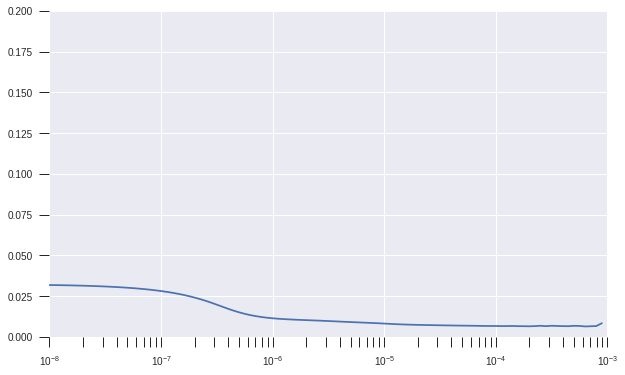

In [17]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_lr.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, .2])
plt.show()

#### Train model with learning rate 1e-4

In [20]:
model = build_model(N_PAST, N_FEATURES, lr=6e-4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 60)            2160      
                                                                 
 bidirectional (Bidirectiona  (None, 24, 128)          64000     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 128)          98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24, 32)            4128      
                                                                 
 dense_1 (Dense)             (None, 24, 10)            330       
                                                                 
 dense_2 (Dense)             (None, 24, 7)             7

In [21]:
history = model.fit(train_set ,epochs=100, validation_data=valid_set, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
   1347/Unknown - 35s 21ms/step - loss: 0.0103 - mae: 0.0822
Epoch 1: val_mae improved from 0.09921 to 0.06768, saving model to model.h5
1349/1349 [==============================] - 57s 37ms/step - loss: 0.0103 - mae: 0.0822 - val_loss: 0.0079 - val_mae: 0.0677
Epoch 2/100
1348/1349 [============================>.] - ETA: 0s - loss: 0.0082 - mae: 0.0697
Epoch 2: val_mae improved from 0.06768 to 0.06408, saving model to model.h5
1349/1349 [==============================] - 34s 25ms/step - loss: 0.0082 - mae: 0.0697 - val_loss: 0.0075 - val_mae: 0.0641
Epoch 3/100
1346/1349 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0650
Epoch 3: val_mae improved from 0.06408 to 0.06254, saving model to model.h5
1349/1349 [==============================] - 33s 25ms/step - loss: 0.0076 - mae: 0.0650 - val_loss: 0.0075 - val_mae: 0.0625
Epoch 4/100
1349/1349 [==============================] - ETA: 0s - loss: 0.0073 - mae: 0.0624
Epoch 4: val_mae improved from 0.06254 to 

In [22]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

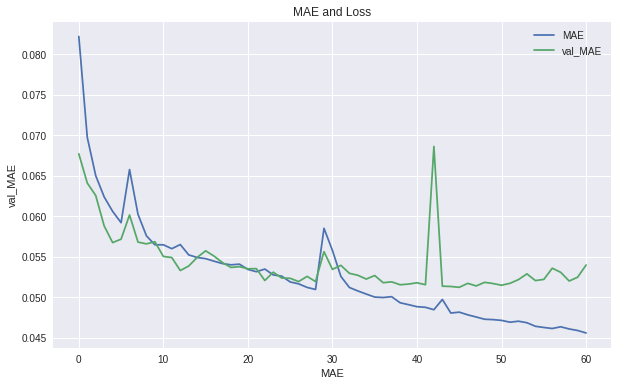

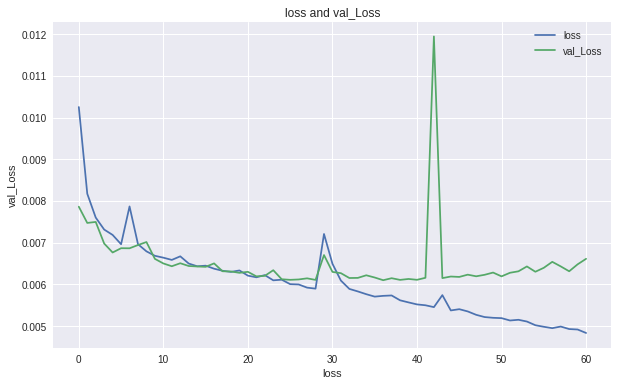

In [23]:
mae = history.history['mae']
loss = history.history['loss']

val_mae = history.history['val_mae']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 

plot_series(x=epochs,
            y=(mae, val_mae), 
            title='MAE and Loss', 
            xlabel='MAE',
            ylabel='val_MAE',
            legend=['MAE', 'val_MAE'])

plot_series(x=epochs,
            y=(loss, val_loss), 
            title='loss and val_Loss', 
            xlabel='loss',
            ylabel='val_Loss',
            legend=['loss', 'val_Loss'])


### Download Model

In [ ]:
from google.colab import files
files.download('model.h5')